In [1]:
!pip install tensorflow

  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [2]:
!pip install keras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error,r2_score
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor



Using TensorFlow backend.


In [6]:
data = pd.read_csv("timeseries_train.csv", sep = ";")
data

,dates,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,...,"France: Paris Stock Market: Price Index: CAC 40 (AVG, Dec-31-87=1000)","Germany: Stock Market Indexes: DAX Performance Index (AVG, Dec-30-87=1000)","Germany: Deutsche Boerse Market Capitalization (EOP, Mil.Euros)","Italy: Stock Price Index: FTSE MIB (AVG, Dec-31-97=24401.54)","Italy: Borsa Italiana Market Capitalization (EOP, Mil.EUR)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)","U.K.: London Stock Exchange: FTSE 100 (EOP, Jan-2-84=1000)","UK: London Stock Exchange Market Capitalization (EOP, Mil.EUR)",CRSP_SPvw
0,31/01/70,NaN,NaN,0.700347,NaN,NaN,NaN,NaN,0.034473,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.075398
1,28/02/70,0.1055,-0.8764,0.670148,0.0005,0.0002,-0.0008,-0.0042,0.035855,-0.000617,...,NaN,NaN,NaN,NaN,NaN,-0.052014,3.491356,NaN,NaN,0.059521
2,31/03/70,0.1051,-0.8842,0.690327,-0.0074,-0.0009,-0.0015,0.0010,0.035842,-0.000417,...,NaN,NaN,NaN,NaN,NaN,5.830915,4.877206,NaN,NaN,0.002806
3,30/04/70,0.1050,-0.6535,0.736751,-0.0050,-0.0001,0.0007,0.0038,0.035712,-0.000100,...,NaN,NaN,NaN,NaN,NaN,-0.186356,-14.638008,NaN,NaN,-0.088831
4,31/05/70,0.1052,-0.6576,0.774228,-0.0012,0.0028,0.0028,0.0044,0.038661,0.000275,...,NaN,NaN,NaN,NaN,NaN,-17.819392,-1.173458,NaN,NaN,-0.054689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,31/08/09,-2.2805,16.7640,0.237594,0.0000,-0.0015,-0.0051,-0.0015,-0.008173,-0.000008,...,9.720526,8.620088,-0.412412,11.448841,6.690895,7.350982,1.740772,6.316916,4.972421,0.034751
476,30/09/09,-2.3337,14.3530,0.232310,-0.0001,-0.0013,-0.0027,-0.0012,-0.000063,-0.000042,...,5.304972,3.439032,3.729266,5.691791,4.732059,-1.229733,-5.469457,4.481572,1.638849,0.036534
477,31/10/09,-2.1085,70.3855,0.232299,-0.0005,0.0002,-0.0002,0.0017,0.003146,-0.000042,...,1.258146,1.705828,-4.673914,2.451208,-4.411161,-2.323525,-1.204183,-1.754724,-1.057252,-0.018259
478,30/11/09,-2.1539,40.9009,0.218105,-0.0005,0.0004,0.0003,-0.0014,0.007464,-0.000017,...,-0.724043,-0.669130,2.764711,-3.207440,-2.112982,-4.316345,-6.312860,2.855020,0.632146,0.060257


In [228]:
data.columns

Index(['dates', 'D12', 'E12', 'b/m', 'tbl', 'AAA', 'BAA', 'lty', 'ntis',
       'Rfree',
       ...
       'France: Paris Stock Market: Price Index: CAC 40 (AVG, Dec-31-87=1000)',
       'Germany: Stock Market Indexes: DAX Performance Index (AVG, Dec-30-87=1000)',
       'Germany: Deutsche Boerse Market Capitalization (EOP, Mil.Euros)',
       'Italy: Stock Price Index: FTSE MIB (AVG, Dec-31-97=24401.54)',
       'Italy: Borsa Italiana Market Capitalization (EOP, Mil.EUR)',
       'Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)',
       'Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)',
       'U.K.: London Stock Exchange: FTSE 100 (EOP, Jan-2-84=1000)',
       'UK: London Stock Exchange Market Capitalization (EOP, Mil.EUR)',
       'CRSP_SPvw'],
      dtype='object', length=163)

In [229]:
#I rank of percentage of NaN values for each columns 
all_data_na = (data.isnull().sum() / len(data)) * 100
all_data_na = all_data_na.sort_values(ascending=False)[:163]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(163)


,Missing Ratio
"Italy: Stock Price Index: FTSE MIB (AVG, Dec-31-97=24401.54)",70.000000
"Germany: Stock Market Indexes: DAX Performance Index (AVG, Dec-30-87=1000)",65.208333
"Italy: Borsa Italiana Market Capitalization (EOP, Mil.EUR)",62.708333
ACOGNO,55.416667
"UK: London Stock Exchange Market Capitalization (EOP, Mil.EUR)",54.791667
"Germany: Deutsche Boerse Market Capitalization (EOP, Mil.Euros)",52.708333
"Canada: TSX Group Market Capitalization (EOP, Mil.C$)",52.708333
"France: Paris Stock Market: Price Index: CAC 40 (AVG, Dec-31-87=1000)",45.208333
"EU 27: MSCI Share Price Index ex Div, LocCur (NSA, EOP, Dec-87=100)",45.000000
"U.K.: London Stock Exchange: FTSE 100 (EOP, Jan-2-84=1000)",35.208333


I am going to drop the columns with less than 10 years observations, so with more than 120 NaNs

In [230]:
columns_to_drop = data.loc[:, np.sum(data.isnull()) > 120].columns
columns_to_drop

Index(['ACOGNO', 'Canada: TSX Group Market Capitalization (EOP, Mil.C$)',
       'EU 27: MSCI Share Price Index ex Div, LocCur (NSA, EOP, Dec-87=100)',
       'France: Paris Stock Market: Price Index: CAC 40 (AVG, Dec-31-87=1000)',
       'Germany: Stock Market Indexes: DAX Performance Index (AVG, Dec-30-87=1000)',
       'Germany: Deutsche Boerse Market Capitalization (EOP, Mil.Euros)',
       'Italy: Stock Price Index: FTSE MIB (AVG, Dec-31-97=24401.54)',
       'Italy: Borsa Italiana Market Capitalization (EOP, Mil.EUR)',
       'U.K.: London Stock Exchange: FTSE 100 (EOP, Jan-2-84=1000)',
       'UK: London Stock Exchange Market Capitalization (EOP, Mil.EUR)'],
      dtype='object')

In [231]:
data = data.drop(columns_to_drop, axis = 1) 

In [232]:
print("dimension after dropping: {}".format(data.shape))

dimension after dropping: (480, 153)


In [233]:
# I drop this column too, since in the test set has all nan values
data.drop('csp', axis = 1, inplace = True)

In [234]:
data.shape

(480, 152)

Below, the list which contains all the names of the columns with at least one NaN value

In [235]:
NaN = data.loc[:,data.isnull().mean() > 0*100].columns # columns with at least one NaN
NaN = NaN.to_list()
NaN # 15 of the remaining columns have at least 1 NaN


['D12',
 'E12',
 'tbl',
 'AAA',
 'BAA',
 'lty',
 'Rfree',
 'D/Y',
 'E/P 10y',
 'TWEXAFEGSMTHx',
 'UMCSENTx',
 'Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)',
 'Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)',
 'Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)',
 'Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)']

In [236]:
data.loc[:, np.sum(data.isnull()) >= 1]

,D12,E12,tbl,AAA,BAA,lty,Rfree,D/Y,E/P 10y,TWEXAFEGSMTHx,UMCSENTx,"Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)","Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1055,-0.8764,0.0005,0.0002,-0.0008,-0.0042,-0.000617,-0.987621,NaN,NaN,NaN,NaN,4.102746,-0.052014,3.491356
2,0.1051,-0.8842,-0.0074,-0.0009,-0.0015,0.0010,-0.000417,-1.037922,NaN,NaN,NaN,NaN,0.775571,5.830915,4.877206
3,0.1050,-0.6535,-0.0050,-0.0001,0.0007,0.0038,-0.000100,-1.038323,NaN,NaN,NaN,NaN,-12.404421,-0.186356,-14.638008
4,0.1052,-0.6576,-0.0012,0.0028,0.0028,0.0044,0.000275,-0.942430,NaN,NaN,NaN,NaN,-10.282468,-17.819392,-1.173458
5,0.1048,-0.6621,0.0033,0.0037,0.0027,-0.0034,-0.000133,-0.878478,NaN,NaN,NaN,NaN,4.608942,2.151437,2.082474
6,0.1047,-0.9708,-0.0016,-0.0004,0.0015,-0.0022,-0.000192,-0.826104,NaN,NaN,NaN,NaN,6.638408,0.962617,2.403121
7,0.1049,-0.9805,-0.0023,-0.0031,0.0004,0.0007,-0.000033,-0.895788,NaN,NaN,NaN,NaN,4.163708,1.226315,-1.054275
8,0.1044,-0.9900,-0.0004,-0.0004,-0.0005,-0.0014,-0.000242,-0.938242,NaN,NaN,NaN,NaN,6.058807,-1.548835,-2.611885
9,-0.5239,-1.4407,-0.0029,-0.0006,-0.0006,0.0013,-0.000175,-0.975947,NaN,NaN,NaN,NaN,-1.669424,-0.893285,2.208822


In [237]:
data.describe()

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,ltr,...,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,"Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)","Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)",CRSP_SPvw
count,479.000000,479.000000,480.000000,479.000000,479.000000,479.000000,479.000000,480.000000,479.000000,480.000000,...,480.000000,480.000000,480.000000,480.000000,480.000000,395.000000,479.000000,479.000000,479.000000,480.000000
mean,0.408698,0.456268,0.522211,-0.000162,-0.000055,-0.000052,-0.000049,0.011185,-0.000014,0.007382,...,-0.001141,-0.001588,-0.004171,0.001352,20.558079,0.620671,0.570901,0.307894,0.607270,0.008978
std,0.585932,6.001773,0.296665,0.005071,0.002542,0.002445,0.003381,0.020329,0.000423,0.031201,...,0.639619,2.410095,1.274555,1.124985,7.468124,4.077185,5.883142,4.730368,5.250364,0.045127
min,-2.333700,-52.828000,0.120510,-0.046200,-0.011800,-0.010200,-0.016400,-0.057654,-0.003850,-0.112400,...,-3.449091,-14.429009,-7.647989,-8.089393,10.484200,-24.201664,-31.683606,-28.500410,-22.129527,-0.215795
25%,0.108300,-0.678400,0.274474,-0.001550,-0.001200,-0.001300,-0.001800,0.001205,-0.000129,-0.010500,...,-0.238611,-0.929368,-0.535347,-0.593550,15.661175,-1.403755,-2.376727,-1.843206,-2.335465,-0.015899
50%,0.479500,0.738700,0.440460,0.000000,-0.000100,-0.000100,-0.000100,0.013372,0.000000,0.007800,...,0.001171,0.038803,0.083713,0.057688,18.926000,0.768887,0.942354,0.629102,0.880259,0.011994
75%,0.792300,1.802500,0.748185,0.001600,0.001100,0.001100,0.001700,0.026438,0.000133,0.024325,...,0.239743,0.956693,0.545772,0.637575,23.545775,3.241493,4.092420,3.135632,3.826297,0.038461
max,1.716900,70.385500,1.206530,0.026100,0.012900,0.015700,0.011400,0.045747,0.002175,0.152300,...,5.959410,13.810457,8.497566,4.962298,67.151000,10.973745,19.069660,14.219130,16.898864,0.168113


Now, I set the dates columns as our index, in order to handle better the dataframe

Before to go ahead, I fill the nan values with the mean

In [238]:
data.describe()

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,ltr,...,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,"Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)","Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)",CRSP_SPvw
count,479.000000,479.000000,480.000000,479.000000,479.000000,479.000000,479.000000,480.000000,479.000000,480.000000,...,480.000000,480.000000,480.000000,480.000000,480.000000,395.000000,479.000000,479.000000,479.000000,480.000000
mean,0.408698,0.456268,0.522211,-0.000162,-0.000055,-0.000052,-0.000049,0.011185,-0.000014,0.007382,...,-0.001141,-0.001588,-0.004171,0.001352,20.558079,0.620671,0.570901,0.307894,0.607270,0.008978
std,0.585932,6.001773,0.296665,0.005071,0.002542,0.002445,0.003381,0.020329,0.000423,0.031201,...,0.639619,2.410095,1.274555,1.124985,7.468124,4.077185,5.883142,4.730368,5.250364,0.045127
min,-2.333700,-52.828000,0.120510,-0.046200,-0.011800,-0.010200,-0.016400,-0.057654,-0.003850,-0.112400,...,-3.449091,-14.429009,-7.647989,-8.089393,10.484200,-24.201664,-31.683606,-28.500410,-22.129527,-0.215795
25%,0.108300,-0.678400,0.274474,-0.001550,-0.001200,-0.001300,-0.001800,0.001205,-0.000129,-0.010500,...,-0.238611,-0.929368,-0.535347,-0.593550,15.661175,-1.403755,-2.376727,-1.843206,-2.335465,-0.015899
50%,0.479500,0.738700,0.440460,0.000000,-0.000100,-0.000100,-0.000100,0.013372,0.000000,0.007800,...,0.001171,0.038803,0.083713,0.057688,18.926000,0.768887,0.942354,0.629102,0.880259,0.011994
75%,0.792300,1.802500,0.748185,0.001600,0.001100,0.001100,0.001700,0.026438,0.000133,0.024325,...,0.239743,0.956693,0.545772,0.637575,23.545775,3.241493,4.092420,3.135632,3.826297,0.038461
max,1.716900,70.385500,1.206530,0.026100,0.012900,0.015700,0.011400,0.045747,0.002175,0.152300,...,5.959410,13.810457,8.497566,4.962298,67.151000,10.973745,19.069660,14.219130,16.898864,0.168113


In [239]:
#fill the NaN using the mean
data.fillna(data.mean(), inplace = True)

In [240]:
# verify if the trasfrom function worked and if still there are any miss values  
data.isnull().any().sum()

0

Let's check the type of data present in our dataframe

In [241]:
d_cont = data.select_dtypes(include = 'float64')
d_cat = data.select_dtypes(exclude = 'float64')

In [242]:
d_cont

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,ltr,...,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,"Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)","Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)",CRSP_SPvw
0,0.408698,0.456268,0.700347,-0.000162,-0.000055,-0.000052,-0.000049,0.034473,-0.000014,-0.0021,...,0.191917,-1.070738,-1.821863,-1.823536,16.2759,0.620671,0.570901,0.307894,0.607270,-0.075398
1,0.105500,-0.876400,0.670148,0.000500,0.000200,-0.000800,-0.004200,0.035855,-0.000617,0.0587,...,-1.651119,0.342668,0.466528,-0.245038,17.6779,0.620671,4.102746,-0.052014,3.491356,0.059521
2,0.105100,-0.884200,0.690327,-0.007400,-0.000900,-0.001500,0.001000,0.035842,-0.000417,-0.0068,...,0.767396,0.243123,-0.271828,2.857575,17.4539,0.620671,0.775571,5.830915,4.877206,0.002806
3,0.105000,-0.653500,0.736751,-0.005000,-0.000100,0.000700,0.003800,0.035712,-0.000100,-0.0413,...,0.106014,1.155765,0.762551,0.395842,18.3914,0.620671,-12.404421,-0.186356,-14.638008,-0.088831
4,0.105200,-0.657600,0.774228,-0.001200,0.002800,0.002800,0.004400,0.038661,0.000275,-0.0468,...,0.282581,-0.360361,-0.160888,-1.934758,37.6526,0.620671,-10.282468,-17.819392,-1.173458,-0.054689
5,0.104800,-0.662100,0.793381,0.003300,0.003700,0.002700,-0.003400,0.042291,-0.000133,0.0486,...,0.327742,0.465830,0.758026,0.429053,23.7760,0.620671,4.608942,2.151437,2.082474,-0.049032
6,0.104700,-0.970800,0.738708,-0.001600,-0.000400,0.001500,-0.002200,0.043074,-0.000192,0.0319,...,0.174020,-3.447940,-1.827710,0.935810,21.3723,0.620671,6.638408,0.962617,2.403121,0.075523
7,0.104900,-0.980500,0.709278,-0.002300,-0.003100,0.000400,0.000700,0.038729,-0.000033,-0.0019,...,0.410235,4.670601,1.903476,1.304921,21.3772,0.620671,4.163708,1.226315,-1.054275,0.049778
8,0.104400,-0.990000,0.712915,-0.000400,-0.000400,-0.000500,-0.001400,0.037942,-0.000242,0.0228,...,0.123195,-1.067788,-0.520702,-0.441365,17.5699,0.620671,6.058807,-1.548835,-2.611885,0.034702
9,-0.523900,-1.440700,0.717698,-0.002900,-0.000600,-0.000600,0.001300,0.036962,-0.000175,-0.0109,...,-0.219925,-0.707799,-0.211085,0.333720,17.5570,0.620671,-1.669424,-0.893285,2.208822,-0.009032


In [243]:
d_cat

,dates,HWI
0,31/01/70,-153
1,28/02/70,-36
2,31/03/70,-184
3,30/04/70,-91
4,31/05/70,-194
5,30/06/70,-57
6,31/07/70,-99
7,31/08/70,-29
8,30/09/70,-27
9,31/10/70,-190


In [244]:
data['HWI'] = data['HWI'].astype(float)

x = data.select_dtypes(include = 'float64')

#useful for plot
data['dates'] = pd.to_datetime(data['dates'])


## Target Variable

In [245]:

y = data['CRSP_SPvw']
x.drop('CRSP_SPvw', axis = 1, inplace = True)

/opt/venv/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [246]:
x

,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,ltr,...,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,"Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)","Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)"
0,0.408698,0.456268,0.700347,-0.000162,-0.000055,-0.000052,-0.000049,0.034473,-0.000014,-0.0021,...,-0.029243,0.191917,-1.070738,-1.821863,-1.823536,16.2759,0.620671,0.570901,0.307894,0.607270
1,0.105500,-0.876400,0.670148,0.000500,0.000200,-0.000800,-0.004200,0.035855,-0.000617,0.0587,...,-0.029243,-1.651119,0.342668,0.466528,-0.245038,17.6779,0.620671,4.102746,-0.052014,3.491356
2,0.105100,-0.884200,0.690327,-0.007400,-0.000900,-0.001500,0.001000,0.035842,-0.000417,-0.0068,...,-0.029243,0.767396,0.243123,-0.271828,2.857575,17.4539,0.620671,0.775571,5.830915,4.877206
3,0.105000,-0.653500,0.736751,-0.005000,-0.000100,0.000700,0.003800,0.035712,-0.000100,-0.0413,...,-0.029243,0.106014,1.155765,0.762551,0.395842,18.3914,0.620671,-12.404421,-0.186356,-14.638008
4,0.105200,-0.657600,0.774228,-0.001200,0.002800,0.002800,0.004400,0.038661,0.000275,-0.0468,...,-0.029243,0.282581,-0.360361,-0.160888,-1.934758,37.6526,0.620671,-10.282468,-17.819392,-1.173458
5,0.104800,-0.662100,0.793381,0.003300,0.003700,0.002700,-0.003400,0.042291,-0.000133,0.0486,...,-0.029243,0.327742,0.465830,0.758026,0.429053,23.7760,0.620671,4.608942,2.151437,2.082474
6,0.104700,-0.970800,0.738708,-0.001600,-0.000400,0.001500,-0.002200,0.043074,-0.000192,0.0319,...,-0.029243,0.174020,-3.447940,-1.827710,0.935810,21.3723,0.620671,6.638408,0.962617,2.403121
7,0.104900,-0.980500,0.709278,-0.002300,-0.003100,0.000400,0.000700,0.038729,-0.000033,-0.0019,...,-0.029243,0.410235,4.670601,1.903476,1.304921,21.3772,0.620671,4.163708,1.226315,-1.054275
8,0.104400,-0.990000,0.712915,-0.000400,-0.000400,-0.000500,-0.001400,0.037942,-0.000242,0.0228,...,-0.029243,0.123195,-1.067788,-0.520702,-0.441365,17.5699,0.620671,6.058807,-1.548835,-2.611885
9,-0.523900,-1.440700,0.717698,-0.002900,-0.000600,-0.000600,0.001300,0.036962,-0.000175,-0.0109,...,-0.029243,-0.219925,-0.707799,-0.211085,0.333720,17.5570,0.620671,-1.669424,-0.893285,2.208822


The dataframe is composed by only numerical variables

## Correlation with the SP500 monthly return rate (CRSP_SPvw)

In [247]:
# top 10 variables correlated with the target features 'CRSP_SPvw'
cor = data.corr()

cor.sort_values('CRSP_SPvw', inplace = True, ascending = False)

cor['CRSP_SPvw'][1:20]

Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)        0.745427
S&P 500                                                                  0.659790
S&P: indust                                                              0.653270
S&P PE ratio                                                             0.535205
Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)            0.463284
Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)    0.400496
corpr                                                                    0.315496
Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)         0.277427
ltr                                                                      0.212480
UMCSENTx                                                                 0.186010
RPI                                                                      0.136945
W875RX1                                                                  0.102710
CMRMTSPLx       

In [248]:
#top 10 var- corr negative ones
cor.sort_values('CRSP_SPvw', inplace = True, ascending = True)
cor['CRSP_SPvw'][0:10]

S&P div yield   -0.609288
svar            -0.317676
BAA.1           -0.263663
BAA             -0.260437
AAA.1           -0.235382
AAA             -0.232521
lty             -0.225801
GS10            -0.200896
EXCAUSx         -0.197226
GS5             -0.191929
Name: CRSP_SPvw, dtype: float64

It is very curios, and of course in the same time very interesting, to see that the Canadian market is highly correlated with CRSP_SPvw

## Matrix of the predictors (X)

In [249]:
sc = StandardScaler()

x_scaled = sc.fit_transform(x)

I am going to use the following models:
- Linear regression
- Ridge regression 
- Lasso regression
- Linear regression con polynomial features
- random forest 

Looking on internet I saw that is quite common split the TimeSerees data manually instead to use the test_split as usual. I am going to do the same, the size of the test will be = 0.15

In [250]:
x_scaled_train = x_scaled[:408]
y_train = y[:408]

x_scaled_test = x_scaled[408:]
y_test = y[408:]


## Linear Model


In [69]:

alphas = np.logspace(-2, -.5, 20) 
params = [{'alpha': alphas}]

tss = TimeSeriesSplit()

ridge = Ridge(random_state=90, max_iter=1000)

grid_rid = GridSearchCV(ridge, params, cv=tss, scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'], refit = 'neg_mean_squared_error', n_jobs = -1)

grid_rid.fit(x_scaled_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Ridge(max_iter=1000, random_state=90), n_jobs=-1,
             param_grid=[{'alpha': array([0.01      , 0.01199354, 0.0143845 , 0.01725211, 0.02069138,
       0.02481629, 0.02976351, 0.03569699, 0.04281332, 0.05134833,
       0.06158482, 0.073862  , 0.08858668, 0.10624678, 0.1274275 ,
       0.15283067, 0.18329807, 0.21983926, 0.26366509, 0.31622777])}],
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

/opt/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


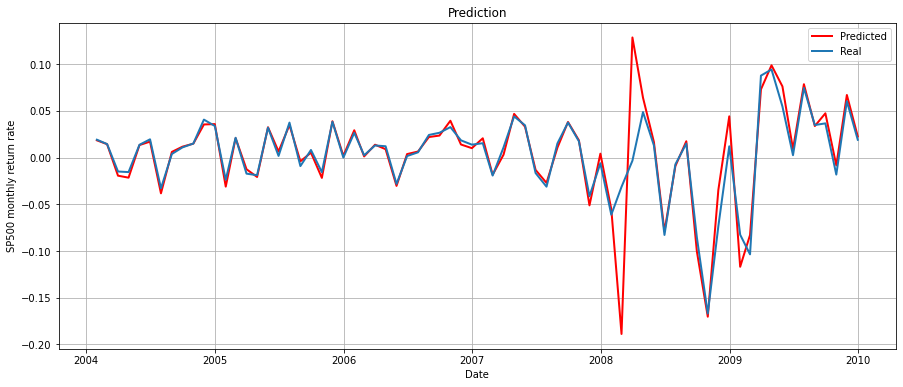

In [70]:
y_pred = grid_rid.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

## New markdown cell

Text(0.5, 1.0, 'MAE')

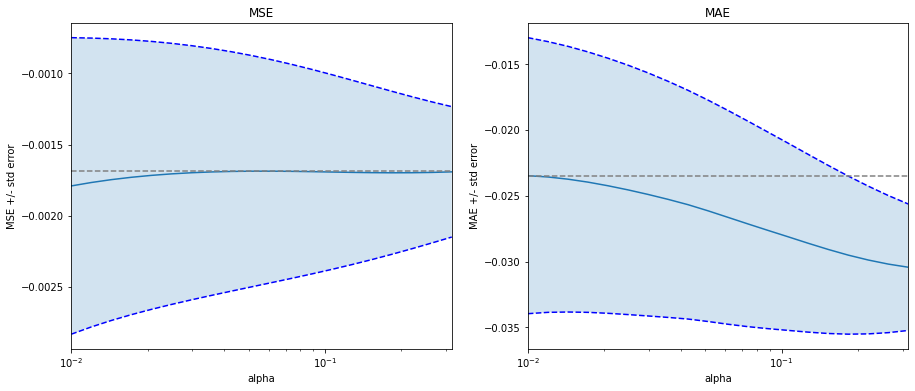

In [72]:
MSE_rid = grid_rid.cv_results_['mean_test_neg_mean_squared_error']
MSE_std_rid = grid_rid.cv_results_['std_test_neg_mean_squared_error']

MAE_rid = grid_rid.cv_results_['mean_test_neg_mean_absolute_error']
MAE_std_rid = grid_rid.cv_results_['std_test_neg_mean_absolute_error']

plt.figure().set_size_inches(15, 6)

ax = plt.subplot(1,2,1)
plt.semilogx(alphas, MSE_rid)
std_error = MSE_std_rid/ np.sqrt(5) # 5 because TimeSeriesSplit has as default value n_folds = 5

plt.semilogx(alphas, MSE_rid + std_error, 'b--')
plt.semilogx(alphas, MSE_rid - std_error, 'b--')

plt.fill_between(alphas, MSE_rid + std_error, MSE_rid - std_error, alpha=0.2)

plt.ylabel('MSE +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(MSE_rid), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.title("MSE")


ax = plt.subplot(1,2,2)
plt.semilogx(alphas, MAE_rid)
std_error = MAE_std_rid/ np.sqrt(5)

plt.semilogx(alphas, MAE_rid + std_error, 'b--')
plt.semilogx(alphas, MAE_rid - std_error, 'b--')

plt.fill_between(alphas, MAE_rid + std_error, MAE_rid - std_error, alpha=0.2)

plt.ylabel('MAE +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(MAE_rid), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.title("MAE")

In [73]:
print(grid_rid.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_rid.cv_results_['rank_test_neg_mean_absolute_error'][0])

20
1


In [74]:
# 19 and 0 comes from the rank returned by 'grid_rid.cv_results_'
print("Best parameter alpha:%s, MSE=%s, MAE=%s" % (grid_rid.best_params_['alpha'], -MSE_rid[19], -MAE_rid[0] ))

Best parameter alpha:0.06158482110660264, MSE=0.0016915929380615178, MAE=0.023470022931047777


## Grid Search - Lasso


In [76]:
alphas = np.logspace(-5, -3.5, 20) 
params = [{'alpha': alphas}]

lasso = Lasso(random_state=90, max_iter=1000)
grid_las = GridSearchCV(lasso, params, cv=tss,scoring = ['neg_mean_squared_error','neg_mean_absolute_error'], refit= 'neg_mean_squared_error', n_jobs = -1)
grid_las.fit(x_scaled_train, y_train)


/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019956937670467363, tolerance: 8.428940747727036e-05
  positive)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Lasso(random_state=90), n_jobs=-1,
             param_grid=[{'alpha': array([1.00000000e-05, 1.19935395e-05, 1.43844989e-05, 1.72521055e-05,
       2.06913808e-05, 2.48162892e-05, 2.97635144e-05, 3.56969885e-05,
       4.28133240e-05, 5.13483291e-05, 6.15848211e-05, 7.38619982e-05,
       8.85866790e-05, 1.06246783e-04, 1.27427499e-04, 1.52830673e-04,
       1.83298071e-04, 2.19839265e-04, 2.63665090e-04, 3.16227766e-04])}],
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

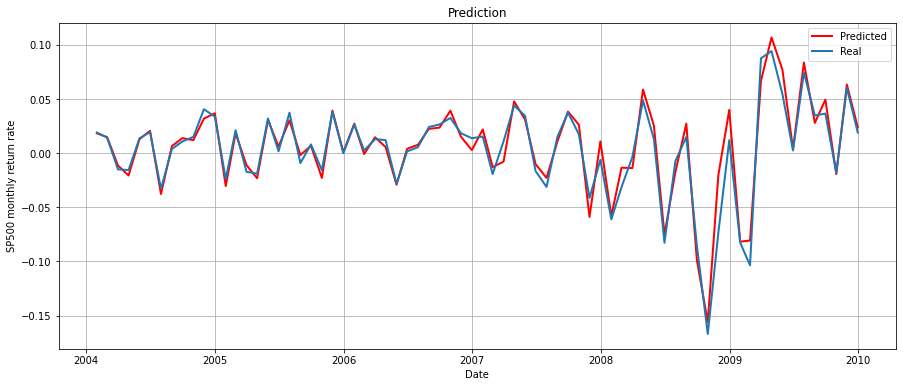

In [77]:
y_pred = grid_las.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

Text(0.5, 1.0, 'MAE')

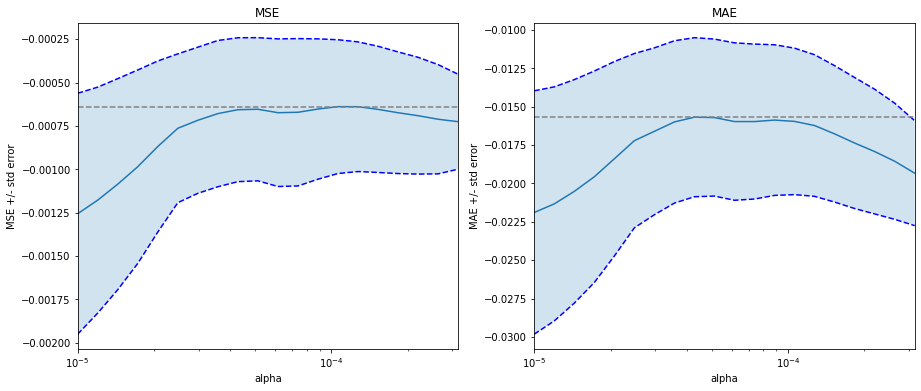

In [78]:
MSE_las = grid_las.cv_results_['mean_test_neg_mean_squared_error']
MSE_std_las = grid_las.cv_results_['std_test_neg_mean_squared_error']

MAE_las = grid_las.cv_results_['mean_test_neg_mean_absolute_error']
MAE_std_las = grid_las.cv_results_['std_test_neg_mean_absolute_error']

plt.figure().set_size_inches(15, 6)

ax = plt.subplot(1,2,1)
plt.semilogx(alphas, MSE_las)
std_error = MSE_std_las/ np.sqrt(5) # 5 because TimeSeriesSplit has as default value n_folds = 5

plt.semilogx(alphas, MSE_las + std_error, 'b--')
plt.semilogx(alphas, MSE_las - std_error, 'b--')

plt.fill_between(alphas, MSE_las + std_error, MSE_las - std_error, alpha=0.2)

plt.ylabel('MSE +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(MSE_las), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.title("MSE")


ax = plt.subplot(1,2,2)
plt.semilogx(alphas, MAE_las)
std_error = MAE_std_las/ np.sqrt(5)

plt.semilogx(alphas, MAE_las + std_error, 'b--')
plt.semilogx(alphas, MAE_las - std_error, 'b--')

plt.fill_between(alphas, MAE_las + std_error, MAE_las - std_error, alpha=0.2)

plt.ylabel('MAE +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(MAE_las), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])
plt.title("MAE")

In [79]:
print(grid_las.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_las.cv_results_['rank_test_neg_mean_absolute_error'][0])

20
20


In [80]:
# 19 and 19 comes from the rank returned by 'grid_rid.cv_results_'
print("Best parameter alpha:%s, MSE=%s, MAE=%s" % (grid_las.best_params_['alpha'], -MSE_las[19], -MAE_las[19] ))

Best parameter alpha:0.0001062467830894041, MSE=0.0007258178285414413, MAE=0.019338014130423305


## As I expected, we got some improvement using Lasso. This was quite predictable since using a datasets with a large numbers of variable, Lasso works also as a features selection

# Polynomial features

In [83]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(x_scaled)

In [84]:
x_scaled_train = X_poly[:408]


x_scaled_test = X_poly[408:]

In [86]:
alphas = np.logspace(-5, -3.5, 20) 
params = [{'alpha': alphas}]

lasso = Lasso(random_state=90, max_iter=1000)


grid_poly = GridSearchCV(lasso, params, cv = tss,scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error'], refit = 'neg_mean_squared_error', n_jobs = -1)
grid_poly.fit(x_scaled_train, y_train)


/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007807488551871233, tolerance: 8.428940747727036e-05
  positive)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Lasso(random_state=90), n_jobs=-1,
             param_grid=[{'alpha': array([1.00000000e-05, 1.19935395e-05, 1.43844989e-05, 1.72521055e-05,
       2.06913808e-05, 2.48162892e-05, 2.97635144e-05, 3.56969885e-05,
       4.28133240e-05, 5.13483291e-05, 6.15848211e-05, 7.38619982e-05,
       8.85866790e-05, 1.06246783e-04, 1.27427499e-04, 1.52830673e-04,
       1.83298071e-04, 2.19839265e-04, 2.63665090e-04, 3.16227766e-04])}],
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

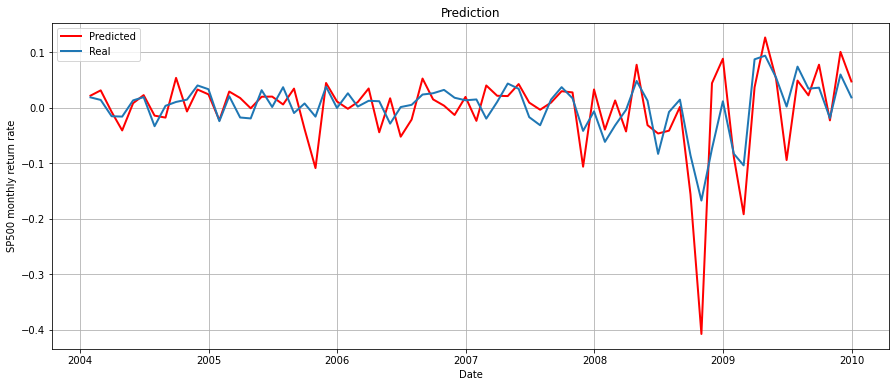

In [87]:
y_pred = grid_poly.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

In [88]:
print(grid_poly.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_poly.cv_results_['rank_test_neg_mean_absolute_error'][0])

20
20


In [89]:
MSE_poly = grid_poly.cv_results_['mean_test_neg_mean_squared_error']
MAE_poly = grid_poly.cv_results_['mean_test_neg_mean_absolute_error']


print("Best parameter:{}, MSE={:.5f}, MAE={:.5f}".format(grid_poly.best_params_, -MSE_poly[14], -MAE_poly[8]))

Best parameter:{'alpha': 1.725210549942039e-05}, MSE=0.00149, MAE=0.02797


## Looking to the MSE we can assume that, in this case,try to improve the model adding flexibility and non linearity is not the right path 

## Random Forest

In [257]:
rf = RandomForestRegressor(n_estimators = 100, oob_score = True) 
params = {'max_depth': [6,8], 'min_samples_split': [12,15,18], 'min_samples_leaf': [2,3,6]}

grid_rf = GridSearchCV(rf, param_grid = params, cv = tss, scoring = ['neg_mean_squared_error','neg_mean_absolute_error' ], refit = 'neg_mean_squared_error',n_jobs = -1)

grid_rf.fit(x_scaled_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=RandomForestRegressor(oob_score=True), n_jobs=-1,
             param_grid={'max_depth': [6, 8], 'min_samples_leaf': [2, 3, 6],
                         'min_samples_split': [12, 15, 18]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

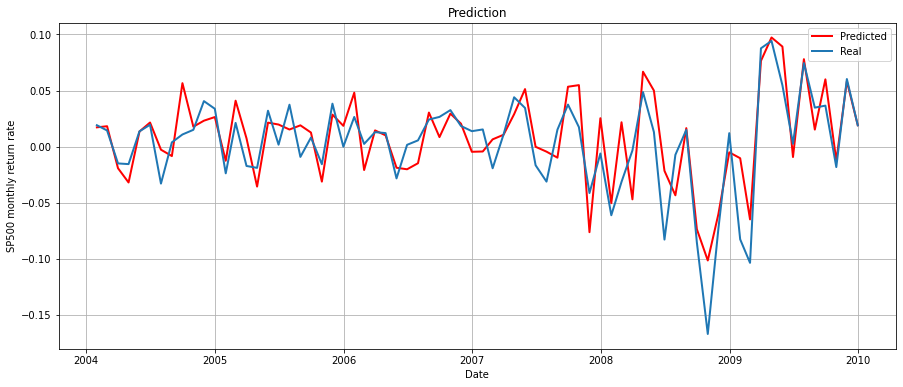

In [258]:
y_pred_rf = grid_rf.predict(x_scaled_test)



plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data.iloc[408:,0], y_pred_rf, color = 'red', lw = 2)
line_true, = plt.plot(data.iloc[408:,0], y_test, lw = 2)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])

In [259]:
print(grid_rf.cv_results_['rank_test_neg_mean_squared_error'][0])
print(grid_rf.cv_results_['rank_test_neg_mean_absolute_error'][0])

5
3


In [260]:
MSE_rf = grid_rf.cv_results_['mean_test_neg_mean_squared_error']
MAE_rf = grid_rf.cv_results_['mean_test_neg_mean_absolute_error']


print("Best parameter:{}, MSE={:.5f}, MAE={:.5f}".format(grid_rf.best_params_, -MSE_rf[7], -MAE_rf[7]))

Best parameter:{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 12}, MSE=0.00092, MAE=0.02280


# C) Best model selection

In [187]:
data_all = pd.read_csv("datasets/timeseries_all.csv", sep = ";")

data_test = pd.read_csv("datasets/timeseries_test.csv", sep = ";")

In [188]:
data_test['csp']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
118   NaN
119   NaN
120   NaN
121   NaN
122   NaN
Name: csp, Length: 123, dtype: float64

In [189]:
# dropping the same columns as the train set
data_test = data_test.drop(columns_to_drop, axis = 1)

In [190]:
# dropping also the target variable and this'csp' that has all NaNs 
data_test = data_test.drop(["Unnamed: 162", "csp"], axis = 1)

In [191]:
# filling with the mean
data_test.fillna(data_test.mean(), inplace = True)

In [192]:
data_test.isna().any().sum()

0

In [194]:
data_test.shape

(123, 151)

In [195]:
data_test


,dates,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,...,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx,"Canada: S&P/TSX Composite Index, Close Price (AVG, 1975=1000)","Canada: MSCI Share Price Index ex Div, US$ (NSA, EOP, Dec-69=100)","Japan: Nikkei Stock Average: TSE 225 Issues (AVG, May-16-49=100)","Japan: 1st Tokyo Stock Exchange: Market Capitalization (EOP, Bil.Yen)"
0,31/01/10,-0.748200,6.310300,0.224117,0.000000,0.000000,-0.001200,-0.001700,0.013350,0.000008,...,1.900000,-0.118648,5.087069,1.032371,-1.298510,19.835400,0.638452,-7.856828,4.730552,-0.341301
1,28/02/10,-0.753800,5.935600,0.218518,0.000100,0.000900,0.000900,0.000000,0.013863,0.000042,...,-0.800000,0.633830,-5.890401,-1.264694,0.263159,21.492500,-1.736329,5.500607,-4.670387,-0.824289
2,31/03/10,-0.759500,5.603000,0.381878,0.000500,-0.000800,-0.000700,0.001700,0.026337,0.000033,...,0.000000,-0.692326,18.730787,-0.097242,-0.619978,16.844200,4.382093,7.742818,4.762919,8.270503
3,30/04/10,0.202200,3.319700,0.376606,0.000400,0.000200,-0.000200,-0.002000,0.026617,0.000008,...,-1.400000,0.227317,-17.590365,0.589606,0.347822,16.058100,1.578305,1.244661,4.294589,2.275318
4,31/05/10,0.201800,3.213100,0.409003,0.000100,-0.003300,-0.002000,-0.003100,0.025683,0.000000,...,1.400000,0.654665,-0.353299,-0.053370,-0.417234,30.798600,-2.879737,-7.266610,-9.759218,-11.267492
5,30/06/10,0.201400,3.113000,0.424177,0.000000,-0.000800,0.001800,-0.003100,0.018726,-0.000033,...,2.400000,-0.160512,0.175682,0.231505,0.130930,28.740700,-1.122428,-5.540779,-3.197150,-4.020987
6,31/07/10,0.476800,2.337100,0.396134,-0.000400,-0.001600,-0.002200,0.000100,0.015518,0.000033,...,-8.200000,0.216323,0.231468,0.301286,2.871140,25.058800,-1.046451,6.713753,-3.421961,0.963538
7,31/08/10,0.474600,2.283700,0.413982,0.000400,-0.002300,-0.003500,-0.004900,0.011120,0.000000,...,1.100000,0.472888,-0.399239,-0.093995,-0.948734,23.990700,1.459717,-2.091690,-2.014479,-5.218407
8,30/09/10,0.472300,2.232700,0.384306,0.000000,0.000400,0.000000,0.001400,0.003239,-0.000008,...,-0.700000,-0.236211,-0.420956,-0.621793,-0.465330,20.889600,3.644078,7.304053,0.843198,2.932173
9,31/10/10,0.559100,2.514700,0.372887,-0.000100,0.001500,0.000600,0.002700,0.007145,-0.000017,...,-0.500000,0.056651,0.699241,-2.323529,-0.034913,19.821700,3.280648,2.899501,1.152774,-2.314285


In [199]:
data_test['dates']

0      31/01/10
1      28/02/10
2      31/03/10
3      30/04/10
4      31/05/10
         ...   
118    30/11/19
119    31/12/19
120    31/01/20
121    29/02/20
122    31/03/20
Name: dates, Length: 123, dtype: object

In [202]:
data_test['HWI'] = data_test['HWI'].astype(float)

x_TEST = data.select_dtypes(include = 'float64')

#useful for plot
data['dates'] = pd.to_datetime(data_test['dates'])

In [204]:

x_TEST = data_test.select_dtypes(include = 'float64')

# scaling
x_TEST_scaled = sc.fit_transform(x_TEST)

# transforming for polynomial
x_TEST_poly = poly.fit_transform(x_TEST_scaled)

# selecting the target variable to compare
y_TEST = data_all.iloc[480:603, -1]

In [205]:
x_TEST_scaled.shape


(123, 150)

In [206]:
y_TEST.shape

(123,)

## Let's predict and evaluate them based on the MSE

In [207]:
# gridsearch with ridge
y_pred_gr = grid_rid.predict(x_TEST_scaled)
mse_gr = mean_squared_error(y_TEST, y_pred_gr)


In [208]:
# gridsearch with lasso
y_pred_gl = grid_las.predict(x_TEST_scaled)
mse_gl = mean_squared_error(y_TEST, y_pred_gl)

In [224]:
#gridsearch with polynomial features
y_pred_gp = grid_poly.predict(x_TEST_poly)
mse_gp = mean_squared_error(y_TEST, y_pred_gp)

In [261]:
# gridsearch with randomforest 
y_pred_grf = grid_rf.predict(x_TEST_scaled)
mse_grf = mean_squared_error(y_TEST, y_pred_grf)

In [264]:
print("MSE(GridSearch with Ridge): {:>27.6f}".format(mse_gr))
print("MSE(GridSearch with Lasso): {:>27.6f}".format(mse_gl))
print("MSE(GridSearch with PolyFeatures): {:.6f}".format(mse_gr))
print("MSE(GridSearch with RandomForest): {:>20.6f}".format(mse_grf))


MSE(GridSearch with Ridge):                    0.045464
MSE(GridSearch with Lasso):                    0.036397
MSE(GridSearch with PolyFeatures): 0.045464
MSE(GridSearch with RandomForest):             0.000892


## The best model is: Random Foreest
### I will plot it and compare it with the real values

In [ ]:
data_test['dates'] = pd.to_datetime(data_test['dates'])

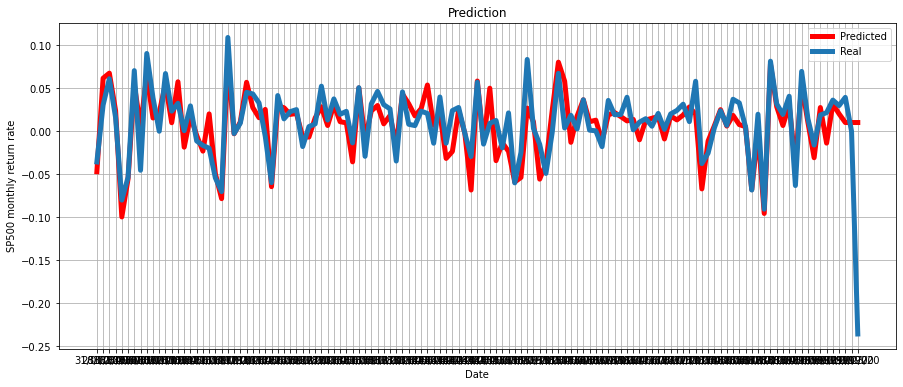

In [263]:
plt.figure().set_size_inches(15, 6)
line_pred, = plt.plot(data_test['dates'], y_pred_grf, color = 'red', lw = 5)
line_true, = plt.plot(data_test['dates'], y_TEST, lw = 5)
plt.grid()

plt.ylabel('SP500 monthly return rate')
plt.xlabel('Date')
plt.title('Prediction')
plt.legend([line_pred, line_true], ['Predicted', 'Real'])